#### Mittausasemat joiden lähistöllä on suoritettu harjausreittejä

In [1]:
import csv
import os
import pandas as pd


### Havaintoasemadatan parsiminen

In [3]:
#MUUTTUMATONTA DATAA, ./data/stations.txt kopioitu osoitteesta https://www.ilmatieteenlaitos.fi/havaintoasemat
# HUOM! Koordinaattidata vain kahden desimaalin tarkkuudella kts. http://opendata.fmi.fi/wfs?service=WFS&version=2.0.0&request=GetFeature&storedquery_id=urban::observations::airquality::hourly::multipointcoverage
# Lähellä sijaitsevien reittien määrä epäluotettava

# file = open("./data/stations.txt", "r", encoding="utf-8")
# text = file.read()
# file.close()

# lines = text.strip().split('\n')
# csv_file = "./data/parsed_stations.csv"
# headers = ["Nimi", "FMSID", "LPNN", "WMO", "Lat", "Lon", "Korkeus", "Ryhmät", "Alkaen"]
# with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file, delimiter=';')
#     writer.writerow(headers)
#     for line in lines:
#         parts = line.split('\t')
#         writer.writerow([part.strip() for part in parts])


In [2]:
df_stations = pd.read_csv("./data/parsed_stations.csv", delimiter=";")
df_stations.head(5)

,Nimi,FMSID,LPNN,WMO,Lat,Lon,Korkeus,Ryhmät,Alkaen
0,Hailuoto Kujalannurkka,104109,NaN,NaN,65.00,24.69,4.0,ilmanlaatu (IL),1995
1,Hailuoto Marjaniemi,101784,5310.0,2873.0,65.04,24.56,7.0,"sää, ilmanlaatu (IL)",1881
2,Helsinki Kumpula,101004,339.0,2998.0,60.20,24.96,24.0,"sää, sade, ilmanlaatu (IL)",2005
3,Hämeenlinna Kotinen,101188,1437.0,NaN,61.24,25.07,158.0,ilmanlaatu (IL),1987
4,Ilomantsi Pötsönvaara,101649,3917.0,2766.0,63.14,31.04,237.0,"sää, ilmanlaatu (IL)",1997


In [3]:
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
import os
dfs = []
json_dir = '../data'
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(json_dir, filename)
        gdf = gpd.read_file(filepath)
        gdf = gdf.to_crs('EPSG:4326')
        dfs.append(gdf)

merged_gdf = gpd.GeoDataFrame(pd.concat(dfs))

### Havaintoasemat ja harjausreitit kartalle

<Axes: >

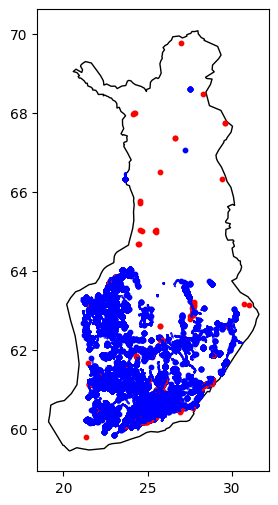

In [4]:
finland = gpd.read_file('./data/suomi.geojson')
ax = finland.plot(figsize=(10, 6), color='white', edgecolor='black')
merged_gdf.plot(ax=ax, color='blue', markersize=10, legend=True)
geometry = [Point(lon, lat) for lon, lat in zip(df_stations['Lon'], df_stations['Lat'])]
gdf = gpd.GeoDataFrame(df_stations, geometry=geometry, crs="EPSG:4326")
gdf.plot(ax=ax, color='red', markersize=10, legend=True)

### Havaintoasemien lähellä olevat reitit

In [5]:
# Sääaseman alueen rajaus
stations = gdf
test_routes = merged_gdf
distance_threshold = 1000
test_routes = test_routes.to_crs("EPSG:3067")
stations = stations.to_crs("EPSG:3067")

# Kilometrin "buffer" alue havaintoasemalle
stations["buffer1000"] = stations.geometry.buffer(1000)
stations["buffer500"] = stations.geometry.buffer(500)
stations["buffer100"] = stations.geometry.buffer(100)


stations['Reitit(1000m)'] = "NaN"
stations['Reitit(500m)'] = "NaN"
stations['Reitit(100m)'] = "NaN"

def calculate_routes(input, i):
    buffer1000_count = 0
    buffer500_count = 0
    buffer100_count = 0
    for route in test_routes.geometry:
        if route.intersects(input['buffer1000']) or route.within(input['buffer1000']):
            buffer1000_count += 1
            if route.intersects(input['buffer500']) or route.within(input['buffer500']):
                buffer500_count += 1
                if route.intersects(input['buffer100']) or route.within(input['buffer100']):
                    buffer100_count  += 1
    input['Reitit(1000m)'] = buffer1000_count
    input['Reitit(500m)'] = buffer500_count
    input['Reitit(100m)'] = buffer100_count
    stations.iloc[i] = input

#Todella pitkä laskenta
for i in range(0,1):
    calculate_routes(stations.iloc[i], i)

In [6]:
#Tarkasta toiminta
stations.head(1)

,Nimi,FMSID,LPNN,WMO,Lat,Lon,Korkeus,Ryhmät,Alkaen,geometry,buffer1000,buffer500,buffer100,Reitit(1000m),Reitit(500m),Reitit(100m)
0,Hailuoto Kujalannurkka,104109,NaN,NaN,65.0,24.69,4.0,ilmanlaatu (IL),1995,POINT (391087.081 7210444.771),"POLYGON ((392087.081 7210444.771, 392082.265 7...","POLYGON ((391587.081 7210444.771, 391584.673 7...","POLYGON ((391187.081 7210444.771, 391186.599 7...",0,0,0


In [7]:
for i in range(1,len(stations)):
    calculate_routes(stations.iloc[i], i)

In [8]:
#Havaintoasemat, joiden lähellä eniten reittejä
stations.sort_values(by=['Reitit(100m)'], ascending=False)

,Nimi,FMSID,LPNN,WMO,Lat,Lon,Korkeus,Ryhmät,Alkaen,geometry,buffer1000,buffer500,buffer100,Reitit(1000m),Reitit(500m),Reitit(100m)
156,Vantaa Kehä III Varisto,104076,NaN,NaN,60.28,24.82,32.0,ilmanlaatu (kaupungit),2013,POINT (379448.406 6684586.885),"POLYGON ((380448.406 6684586.885, 380443.590 6...","POLYGON ((379948.406 6684586.885, 379945.998 6...","POLYGON ((379548.406 6684586.885, 379547.924 6...",299,162,90
155,Vantaa Jätevoimala,104085,NaN,NaN,60.26,25.14,NaN,ilmanlaatu (kaupungit),2014,POINT (397077.823 6681818.109),"POLYGON ((398077.823 6681818.109, 398073.008 6...","POLYGON ((397577.823 6681818.109, 397575.415 6...","POLYGON ((397177.823 6681818.109, 397177.342 6...",379,164,60
55,Imatra Teppanala,103122,NaN,NaN,61.15,28.81,62.0,ilmanlaatu (kaupungit),1994,POINT (597424.739 6780843.236),"POLYGON ((598424.739 6780843.236, 598419.924 6...","POLYGON ((597924.739 6780843.236, 597922.332 6...","POLYGON ((597524.739 6780843.236, 597524.258 6...",96,63,20
105,Lohja Moisio,107543,NaN,NaN,60.25,24.08,48.0,ilmanlaatu (kaupungit),2021,POINT (338395.070 6682830.039),"POLYGON ((339395.070 6682830.039, 339390.254 6...","POLYGON ((338895.070 6682830.039, 338892.662 6...","POLYGON ((338495.070 6682830.039, 338494.588 6...",102,58,19
63,Kaarina Kaarina,100823,NaN,NaN,60.41,22.38,13.0,ilmanlaatu (kaupungit),2004,POINT (245643.727 6705998.062),"POLYGON ((246643.727 6705998.062, 246638.912 6...","POLYGON ((246143.727 6705998.062, 246141.319 6...","POLYGON ((245743.727 6705998.062, 245743.245 6...",232,134,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Kemi Biotuotetehdas,107284,NaN,NaN,65.76,24.54,NaN,ilmanlaatu (kaupungit),2021,POINT (387323.731 7295365.458),"POLYGON ((388323.731 7295365.458, 388318.916 7...","POLYGON ((387823.731 7295365.458, 387821.323 7...","POLYGON ((387423.731 7295365.458, 387423.250 7...",0,0,0
66,Kemi Keskusta,107218,NaN,NaN,65.73,24.56,10.0,ilmanlaatu (kaupungit),2020,POINT (388109.601 7291987.968),"POLYGON ((389109.601 7291987.968, 389104.786 7...","POLYGON ((388609.601 7291987.968, 388607.193 7...","POLYGON ((388209.601 7291987.968, 388209.120 7...",0,0,0
67,Kerava,104104,NaN,NaN,60.40,25.10,50.0,ilmanlaatu (kaupungit),2005,POINT (395314.157 6697469.073),"POLYGON ((396314.157 6697469.073, 396309.342 6...","POLYGON ((395814.157 6697469.073, 395811.750 6...","POLYGON ((395414.157 6697469.073, 395413.676 6...",77,18,0
68,Kirkkonummi keskusta,106953,NaN,NaN,60.13,24.43,21.0,ilmanlaatu (kaupungit),2019,POINT (357238.250 6668666.289),"POLYGON ((358238.250 6668666.289, 358233.435 6...","POLYGON ((357738.250 6668666.289, 357735.842 6...","POLYGON ((357338.250 6668666.289, 357337.769 6...",159,9,0


<Axes: >

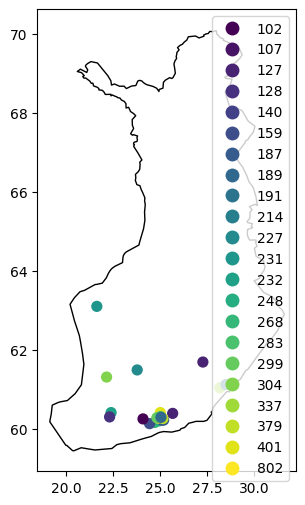

In [9]:
over100 = stations.loc[stations["Reitit(1000m)"] >= 100]
over100 = over100.to_crs("EPSG:4326")


ax = finland.plot(figsize=(10, 6), color='white', edgecolor='black')
over100.plot(ax=ax,markersize=50, column="Reitit(1000m)", cmap="viridis", legend=True)

In [10]:
zero_routes = stations.loc[stations["Reitit(1000m)"] == 0]
one_or_more = stations.loc[stations["Reitit(1000m)"] >= 1]
print(f"Havaintoasemia yhteensä: {len(stations)}")
print(f"0 reittiä sisältävien havaintoasemien määrä: {len(zero_routes)}")
print(f"Yksi tai useampi reitti 1000m säteellä: {len(one_or_more)}")

Havaintoasemia yhteensä: 170
0 reittiä sisältävien havaintoasemien määrä: 77
Yksi tai useampi reitti 1000m säteellä: 93


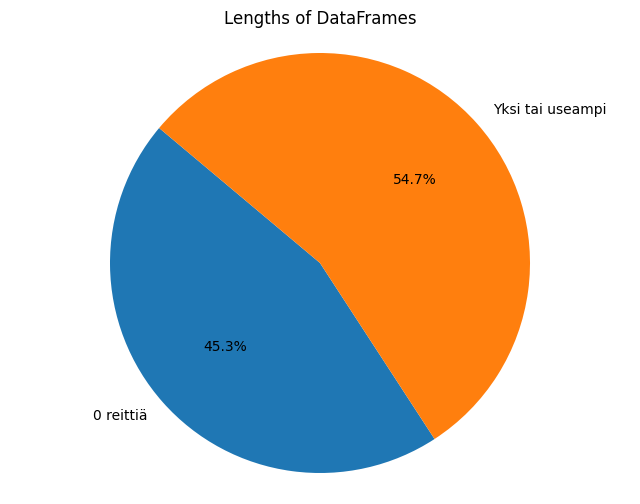

In [11]:
import matplotlib.pyplot as plt

lengths = [len(zero_routes), len(one_or_more)]
labels = ['0 reittiä', 'Yksi tai useampi']

plt.figure(figsize=(8, 6))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Lengths of DataFrames')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

[(0, 0), (1, 50), (51, 100), (101, 150), (151, 200), (201, 250), (251, 300), (301, 350), (351, 400), (401, 450), (451, 500), (501, 550), (551, 600), (601, 650), (651, 700), (701, 750), (751, 800), (801, 850)]


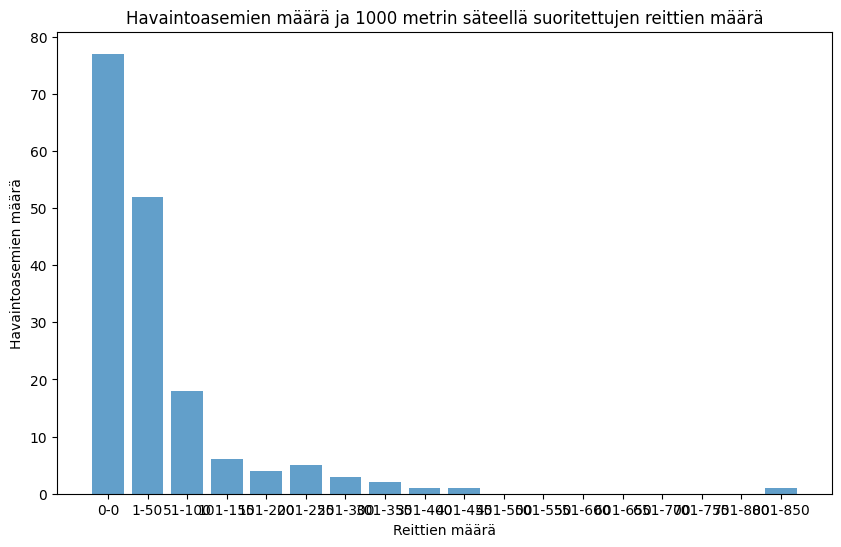

In [12]:
categories = [(0, 0)] + [(i, i+49) for i in range(1, max(stations["Reitit(1000m)"]), 50)]
print(categories)
category_counts = [sum((stations["Reitit(1000m)"] >= start) & (stations["Reitit(1000m)"] <= end)) for start, end in categories]
plt.figure(figsize=(10, 6))
plt.bar(range(len(categories)), category_counts, align='center', alpha=0.7)
plt.xticks(range(len(categories)), [f'{start}-{end}' for start, end in categories])
plt.xlabel('Reittien määrä')
plt.ylabel('Havaintoasemien määrä')
plt.title('Havaintoasemien määrä ja 1000 metrin säteellä suoritettujen reittien määrä')
plt.show()

In [13]:
stations[["Nimi", "Reitit(1000m)","Reitit(500m)", "Reitit(100m)"]].sort_values(by=['Reitit(100m)'], ascending=False).head(5)

,Nimi,Reitit(1000m),Reitit(500m),Reitit(100m)
156,Vantaa Kehä III Varisto,299,162,90
155,Vantaa Jätevoimala,379,164,60
55,Imatra Teppanala,96,63,20
105,Lohja Moisio,102,58,19
63,Kaarina Kaarina,232,134,19


In [14]:
export = stations
export.head(1)
# export.to_csv("./data/stations_and_number_of_routes.csv")

,Nimi,FMSID,LPNN,WMO,Lat,Lon,Korkeus,Ryhmät,Alkaen,geometry,buffer1000,buffer500,buffer100,Reitit(1000m),Reitit(500m),Reitit(100m)
0,Hailuoto Kujalannurkka,104109,NaN,NaN,65.0,24.69,4.0,ilmanlaatu (IL),1995,POINT (391087.081 7210444.771),"POLYGON ((392087.081 7210444.771, 392082.265 7...","POLYGON ((391587.081 7210444.771, 391584.673 7...","POLYGON ((391187.081 7210444.771, 391186.599 7...",0,0,0


In [15]:
export.to_csv("./data/stations_and_number_of_routes.csv", index=False)